# PSSM generation

Generate PSSM files to extract evolutionary features. Using Mmseqs the process can be really fast.  

However, I have found a problem (I don't know if it is an bug or not) in the program and created an issue to the Mmseqs team. So at the moment it is down.

In [3]:
from BioML.utilities.utils import MmseqsClustering

In [4]:
fasta_file = "../data/whole_sequence.fasta"

In [3]:
pssm_file = MmseqsClustering.easy_generate_pssm(input_file=fasta_file, database_input=fasta_file,
output_database="../data/whole_sequence", generate_searchdb=True, pssm_filename="esterase.pssm")

start running createdb
It took 0.008338212966918945 second to run
start running search
It took 2.8009424209594727 second to run
start running generate_profile
It took 0.08434319496154785 second to run
start running convert profile to pssm
It took 0.04231381416320801 second to run


In [4]:
MmseqsClustering.split_pssm(pssm_file)

# Extract Features

There are several features to extract:
   1. Physicochemical features from iFeatures https://github.com/Superzchen/iFeature
   2. It might be great to incorporate other features the Lab is using like the Onehot encoding and the AA index
   3. Evolutionary features using PSSM and Possum https://possum.erc.monash.edu/
   4. Features or embeddings from Large language models 

In [5]:
from BioML.features.extraction import PossumFeatures, IfeatureFeatures, read_features

In [18]:
ifeatures = IfeatureFeatures("/home/ruite/Projects/enzyminer/iFeature")
ifeatures.extract(fasta_file)

iFeature features to be extracted: {'long': ['NMBroto', 'Moran', 'Geary'], 'short': ['CKSAAGP', 'PAAC', 'CTDD', 'GDPC', 'APAAC', 'GAAC', 'GTPC', 'SOCNumber', 'CTDT', 'KSCTriad', 'CTDC', 'CTriad', 'QSOrder']}


start running Ifeature programs
It took 16.37057065963745 second to run


In [14]:
#possum = PossumFeatures(pssm_dir="pssm", program="/home/ruite/Projects/enzyminer/POSSUM_Toolkit")
#possum.extract(fasta_file)

Possum features to be extracted: {'long': ['tri_gram_pssm', 'pssm_cc'], 'short': ['pssm_composition', 'smoothed_pssm:5', 'pse_pssm:3', 'k_separated_bigrams_pssm', 'ab_pssm', 'smoothed_pssm:7', 'd_fpssm', 'pse_pssm:2', 'smoothed_pssm:9', 'rpm_pssm', 'dp_pssm', 'rpssm', 'pse_pssm:1', 'pssm_ac', 'aac_pssm', 'dpc_pssm', 'tpc', 'eedp', 'edp', 's_fpssm']}
start running Possum programs
It took 0.018246889114379883 second to run


##  LLM embeddings

If you want you can easily generate large language model embeddings from models supported by Hugging Face's API

In [6]:
from BioML.deep import embeddings

In [4]:
embeddings.generate_embeddings(fasta_file, model_name="facebook/esm2_t6_8M_UR50D", option="mean", save_path="embeddings.csv", mode="write")

## Feature selection

If we combine features from multiple places the dimensions would be too high to handle, so normally ti would be wise to use some feature selection techniques: 
    1. Supervised: using Tree methods, Recursive feature elmination
    2. Filter methods: Pearson correlation etc
    3. TODO: Unsupervised methods like: PCA, ICA (independent component analysis)

In [7]:
import pandas as pd
from BioML.features import methods, selection

In [8]:
ifeat = read_features("ifeature", ifeature_out="ifeature_features", file_splits=1)
emb = pd.read_csv("embeddings.csv", index_col=0)

In [9]:
emb.columns.shape, ifeat.columns.shape

((320,), (2274,))

The DataReader function takes:
* label in different formats: string, ndarray, a list of pd.Series.
* It also takes features in different formats: a list, ndarray, dataframe, list of dataframes or a list of the different accepted formats and concatenates them

It will automatically remove features with 0 variance (meaning every value is the same), you can control the threshold

In [10]:
features = selection.DataReader("../data/esterase_labels.csv", [ifeat, emb], variance_thres=0.005)
features

Data with:
    num. samples: 147
    num. columns: 937
    variance threshold: 0.005
    sheet: None

Depending on the problem you might use one of the feature selection classes: The name is quite self-explanatory.

The get_range_features retuns a list of feature dimensions to extract and it will generate an excel file with those features, the number of sheets will be len(feature_range) * number of selection algorithms

It will also output an plot of the feature importance with the shap package https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/

In [11]:
problem="classification"

26-05-2024 17:37:00 INFO Reading the features
26-05-2024 17:37:00 INFO Starting feature selection and using the following parameters
26-05-2024 17:37:00 INFO seed: 10
26-05-2024 17:37:00 INFO filtering the features


classification filter: mutual_info
classification filter: Fscore
classification filter: chi2
classification filter: FechnerCorr
classification filter: KendallCorr
generating a feature set of 50 dimensions


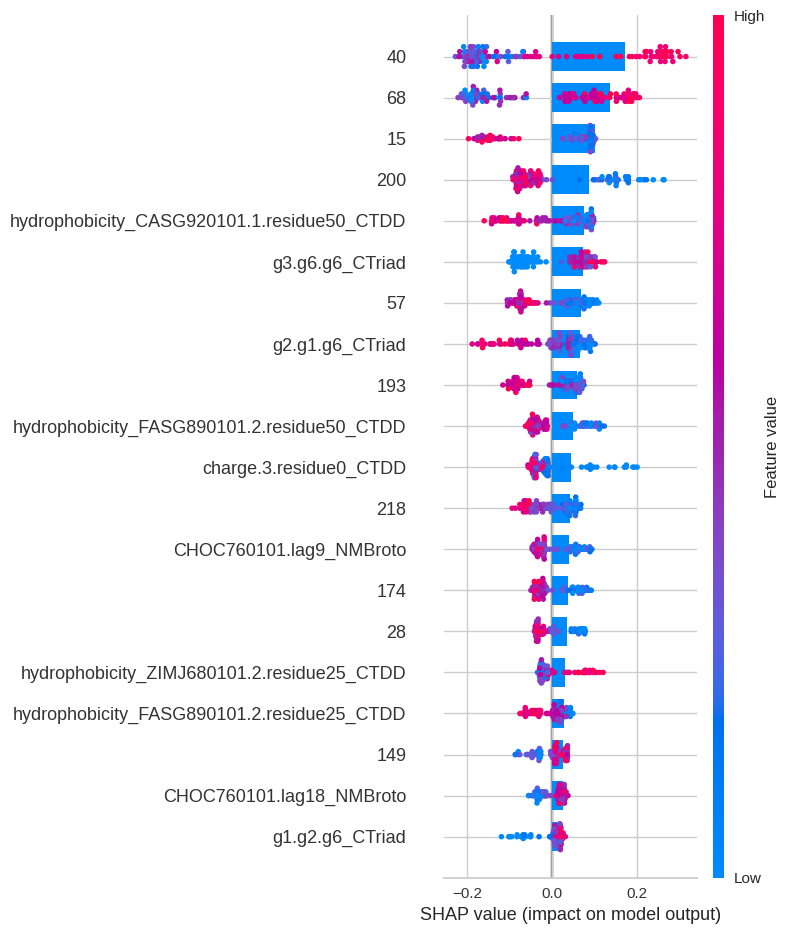

In [12]:
feature_range = selection.get_range_features(features.features, num_features_min =None, num_features_max=None, step_range=None)
filters = selection.FeatureSelection("filtered_features.xlsx", num_thread=1, seed=10)
# select features
if problem == "classification":
    select = selection.FeatureClassification(filters.seed, scaler="robust", test_size=0.2)
elif problem == "regression":
    select = selection.FeatureRegression(filters.seed, scaler="robust", test_size=0.2)
feature_range = [50]
select.construct_features(features.features, features.label, filters, feature_range)

### Outlier detection

You can also eliminate outliers in your dataset that could decrease model performance.
Generally, if you have a lot of data outliers won't matter much
You give it the filtered features:
1. It also accepts different formats: excel files
2. Pandas dataframe
3. Series, ndarray
4. csv file

It leverages 10 different outlier detection algorithms and gives you a voting. If you give it an excel file where there are features on each sheet. It will use all of them.

In [13]:
from BioML.utilities.outlier import OutlierDetection

In [15]:
detection = OutlierDetection("filtered_features.xlsx", num_thread=4)
outliers = detection.run()

using xgbtree_50 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using KendallCorr_50 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using Fscore_50 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using FechnerCorr_50 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using rfe_50 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using chi2_50 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using mutual_info_50 for outlier calculations


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


using random_50 for outlier calculations
saving the outlier file


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.0s finished


In [18]:
outliers.head(20)

EH46(23)     57
EH51(22)     42
EH75(16)     40
EH106(9)     33
EH138(2)     32
EH144(1)     25
EH142(1)     23
EH105(10)    19
EH143(1)     18
EH124(4)     18
EH49(23)     17
EH119(6)     16
EH48(23)     13
EH100(11)    12
EH117(6)     12
CalB(68)     10
EH125(4)     10
EH78(15)     10
EH13(49)     10
EH98(11)      9
dtype: int64

## Custom splitting based on 30% sequence identity

It is recommended to split based on sequence identity so that the training, test or validation sets doesn't have sequence with more than 30% sequence identity.
You can use mmseqs to generate such clusters
It creates a cluster.tsv file

In [19]:
from BioML.utilities.utils import MmseqsClustering
from BioML.utilities.split_methods import ClusterSpliter
from BioML.models.base import DataParser
import pandas as pd
from sklearn.model_selection import train_test_split
from pathlib import Path

Generate different clusters of sequences based on an identity threshold of 30%

In [20]:
cluster = MmseqsClustering.easy_cluster(fasta_file, cluster_at_sequence_identity=0.3)

start running cluster
It took 0.010366439819335938 second to run
start running create tsv
It took 0.020195722579956055 second to run


Now split based on this sequence identity cluster, the clusters can use string or numbers as lon g as it has the same index as the names of the sequences

In [20]:
split = ClusterSpliter("cluster.tsv", 5, random_state=100, stratified=True)
data = DataParser("filtered_features.xlsx", "../data/esterase_labels.csv", sheets="chi2_50")
X_train, X_test, _, _ = split.train_test_split(data.features, data.features[data.label])

/home/ruite/Projects/BioML/BioML/models/base.py:100: UserWarning: The excel file contains more than one sheet, only the sheet chi2_50 will be used
  warnings.warn(f"The excel file contains more than one sheet, only the sheet {sheets} will be used")


## Classification

In [25]:
from BioML.models.classification import Classifier
from BioML.models.base import PycaretInterface, Trainer
from collections import defaultdict
from functools import partial
import pandas as pd
import numpy as np

In [23]:
plot = ("learning", "confusion_matrix", "class_report")

In [26]:
experiment = PycaretInterface("classification", 250, budget_time=20, best_model=3, 
                                  output_path="classification_training", optimize="MCC")
classifier = Classifier(test_size=0.2, optimize="MCC", drop=())
training = Trainer(experiment, classifier, 5, 50)

15-05-2024 22:04:11 INFO ------------------------------------------------------------------------------
15-05-2024 22:04:11 INFO PycaretInterface parameters
15-05-2024 22:04:11 INFO Seed: 250
15-05-2024 22:04:11 INFO Budget time: 20
15-05-2024 22:04:11 INFO The number of models to select: 3
15-05-2024 22:04:11 INFO Output path: classification_training
15-05-2024 22:04:11 INFO ----------------Trainer inputs-------------------------
15-05-2024 22:04:11 INFO Number of kfolds: 5
15-05-2024 22:04:11 INFO Number of retuning iterations: 50


In [27]:
results, models = training.generate_training_results(X_train, data.label, tune=True, test_data=X_test, fold_strategy=split)

2024/05/15 22:06:39 INFO mlflow.tracking.fluent: Experiment with name 'Classification' does not exist. Creating a new experiment.
15-05-2024 22:06:39 INFO --------------------------------------------------------
15-05-2024 22:06:39 INFO Training classification models
15-05-2024 22:06:39 INFO The models used ['lr', 'knn', 'nb', 'dt', 'svm', 'rbfsvm', 'gpc', 'mlp', 'ridge', 'rf', 'qda', 'ada', 'gbc', 'lda', 'et', 'xgboost', 'lightgbm', 'catboost', 'dummy']
15-05-2024 22:06:39 INFO Time budget is 20 minutes
/home/ruite/miniconda3/envs/bioml_pycaret/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
15-05-2024 22:06:43 INFO Model ada trained in 0.062 minutes
15-05-2024 22:06:45 INFO Model svm trained in 0.041 minutes
15-05-2024 22:06:46 INFO Model ridge trained in 0.016 minutes
15-05-2024 22:06:48 INFO Model xgboost trained in 0.02 minutes
15-05-2024 22:06:49 INFO Model nb traine

##### Acces the ClaasificationExperiment from Pycaret and play with the models if you want

In [31]:
test_set_predictions = training.generate_holdout_prediction(models)

In [32]:
training_output = "classification_results"
l = []
for tune_status, result_dict in results.items():
    for key, value in result_dict.items():
        classification.write_results(f"{training_output}/{tune_status}", *value, sheet_name=key)
    classification.write_results(f"{training_output}/{tune_status}", test_set_predictions[tune_status] , sheet_name=f"test_results")

## Save Model from pre-trained

In [45]:
models["tuned"]["holdout"]

{'qda': QuadraticDiscriminantAnalysis(priors=None, reg_param=0.8258792813861613,
                               store_covariance=False, tol=0.0001),
 'knn': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                      metric_params=None, n_jobs=-1, n_neighbors=24, p=2,
                      weights='uniform'),
 'nb': GaussianNB(priors=None, var_smoothing=0.7918521648729947)}

In [33]:
from BioML.models import save_model

In [18]:
generate = save_model.GenerateModel(training)
for status, model in models.items():
    for key, value in model.items():
        if key == "holdout":
            for num, mod in enumerate(value.values()):
                if num > training.experiment.best_model - 1 : break
                final_model = generate.finalize_model(value, num)
                generate.save_model(final_model, f"model_output/{key}_{status}")
        else:
            final_model = generate.finalize_model(value)
            generate.save_model(final_model, f"model_output/{key}_{status}")

28-03-2024 12:38:51 INFO ----------Finalizing the model by training it with all the data including test set--------------


Transformation Pipeline and Model Successfully Saved


## Save Model from scratch

In [12]:
from BioML.models import save_model

In [17]:
data = save_model.DataParser("../data/esterase_features.xlsx", "../data/esterase_labels.csv", sheets="ch2_20")
experiment = save_model.PycaretInterface("classification", 200, budget_time=20, best_model=3, 
                                  output_path="classification_training", optimize="MCC", experiment_name="generate_model")
classifier = save_model.Classifier(test_size=0.2, optimize="MCC", selected=("qda", "rbfsvm", "ridge"))
training = save_model.Trainer(experiment, classifier, 5, 30)


27-03-2024 14:28:52 INFO ------------------------------------------------------------------------------
27-03-2024 14:28:52 INFO PycaretInterface parameters
27-03-2024 14:28:52 INFO Seed: 200
27-03-2024 14:28:52 INFO Budget time: 20
27-03-2024 14:28:52 INFO The number of models to select: 3
27-03-2024 14:28:52 INFO Output path: classification_training
27-03-2024 14:28:52 INFO ----------------Trainer inputs-------------------------
27-03-2024 14:28:52 INFO Number of kfolds: 5
27-03-2024 14:28:52 INFO Number of iterations: 30


In [19]:
sorted_results, sorted_models, top_params = training.run_training(data.features, data.label)

2024/03/27 14:28:55 INFO mlflow.tracking.fluent: Experiment with name 'generate_model' does not exist. Creating a new experiment.
27-03-2024 14:28:56 INFO --------------------------------------------------------
27-03-2024 14:28:56 INFO Training classification models
27-03-2024 14:28:56 INFO The models used ['lr']
27-03-2024 14:28:56 INFO Time budget is 20 minutes
27-03-2024 14:29:01 INFO Model lr trained in 0.092 minutes
27-03-2024 14:29:01 INFO Training over: Total runtime 0.092 minutes


Model lr trained in 0.092 minutes


In [20]:
generate = save_model.GenerateModel(training)
models =  generate.train_by_strategy(sorted_models, "majority")
final_model = generate.finalize_model(models)
generate.save_model(final_model, "model_output/logistic")

27-03-2024 14:29:02 INFO ----------Finalizing the model by training it with all the data including test set--------------


Transformation Pipeline and Model Successfully Saved


## Prediction

In [34]:
from BioML.models import predict
import pandas as pd
import numpy as np
from scipy.spatial import distance

In [23]:
training_features = "filtered_features.xlsx"
label = "../data/esterase_labels.csv"
outlier_train=()
outlier_test=()
sheet_name="chi2_50"
problem="classification"
model_path="model_output/majority"
scaler="robust"

#### generate the predictions

In [40]:
feature = predict.DataParser(training_features, label, outliers=outlier_train, sheets=sheet_name)
test_features = feature.remove_outliers(feature.read_features(test_features, "chi2_50"), outlier_test)
predictions = predict.predict(test_features, model_path, problem)


#### Optional if you want to filter predictions based if that test sample is within the applicability domain

Applicability domain compares eucleadian distance between the features from the training and features from the test.   
If the distance is far from a set threshold then that prediction is discarded since it deviates from the samples the model have seen during training

In [41]:
transformed, scaler_dict, test_x = predict.scale(scaler, feature.drop(), test_features)
filtered_pred = predict.domain_filter(predictions, transformed, test_x, 5) # it returns the predictions appended to the features

In [44]:
filtered_pred.shape, predictions.shape

((120, 20), (147, 19))

In [ ]:
 # if you don't apply the domain filter, you can just use the predictions but you have to change the index to sample_0, sample_1, etc
predictions.index = [f"sample_{x}" for x, _ in enumerate(predictions.index)]
col_name = ["prediction_score", "prediction_label", "AD_number"]
predictions = predictions.loc[:, predictions.columns.str.contains("|".join(col_name))] # only keep the columns with the prediction scores

### Separate the fasta file into positive or negative

In [34]:
fasta = "../data/whole_sequence.fasta"
res_dir = "prediction_results_domain"

In [35]:
extractor = predict.FastaExtractor(fasta, res_dir)
positive, negative = extractor.separate_negative_positive(predictions)


In [36]:
extractor.extract(positive, negative, positive_fasta=f"positive.fasta", negative_fasta=f"negative.fasta")